### Background
As smart phone penetration reaches the hundreds of millions mark, O2O (Online to Offline) requires businesses to have a strong presence both offline and online. APPs with O2O capabilities accumulate daily consumer behaviour and location data that require big data and commercial operations management. The competition at hand focuses on coupon redemption rates. Sending coupons is a general O2O marketing tool used to activate existing customers and attract new ones. While customers are happy to receive coupons that they want, they are frustrated when receiving coupons that they do not need. For merchants, sending unwanted coupons may erode brand equity and hinder marketing expense forecasting. Targeted marketing is an important technology to increase the coupon redemption rate, providing relevant discounts to customers and effective marketing tools to businesses. The competition provides participants with abundant O2O data in this field and expects contestants to predict whether the customer will use the coupon within a specified time frame.
### Data
This competition provides real online and offline user consumption data from January 1, 2016 to June 30, 2016. The contestants are expected to predict the probability of customers redeeming a coupon within 15 days of receiving it.
Note: To protect the privacy of users and merchants, data is desensitized and under biased sampling.
### Evaluation
The results are evaluated based on the average AUC value. That is, the AUC value is calculated for every coupon_id. The average of each AUC value is the evaluation score. More information on AUC value calculation method on wikipedia.


In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

### Online and Offline Training data

In [2]:
df_on = pd.read_csv('ccf_online_stage1_train.csv')
df_off = pd.read_csv('ccf_offline_stage1_train.csv')

In [3]:
print("Online Training Data Sample\nShape:"+str(df_on.shape))
df_on.head()

Online Training Data Sample
Shape:(11429826, 7)


,User_id,Merchant_id,Action,Coupon_id,Discount_rate,Date_received,Date
0,13740231,18907,2,100017492,500:50,20160513.0,NaN
1,13740231,34805,1,NaN,NaN,NaN,20160321.0
2,14336199,18907,0,NaN,NaN,NaN,20160618.0
3,14336199,18907,0,NaN,NaN,NaN,20160618.0
4,14336199,18907,0,NaN,NaN,NaN,20160618.0


In [4]:
print("Offline Training Data Sample\nShape:"+str(df_off.shape))
df_off.head()

Offline Training Data Sample
Shape:(1754884, 7)


,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
0,1439408,2632,NaN,NaN,0.0,NaN,20160217.0
1,1439408,4663,11002.0,150:20,1.0,20160528.0,NaN
2,1439408,2632,8591.0,20:1,0.0,20160217.0,NaN
3,1439408,2632,1078.0,20:1,0.0,20160319.0,NaN
4,1439408,2632,8591.0,20:1,0.0,20160613.0,NaN


### Test Data (Offline)

In [5]:
df_test = pd.read_csv('ccf_offline_stage1_test_revised.csv')
print("Testing Data(Offline) Sample\nShape:"+str(df_test.shape))
df_test.head()

Testing Data(Offline) Sample
Shape:(113640, 6)


,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received
0,4129537,450,9983,30:5,1.0,20160712
1,6949378,1300,3429,30:5,NaN,20160706
2,2166529,7113,6928,200:20,5.0,20160727
3,2166529,7113,1808,100:10,5.0,20160727
4,6172162,7605,6500,30:1,2.0,20160708


#### Converting Date to DateTime format

In [6]:
#Online Training Data
df_on['Date'] = pd.to_datetime(df_on["Date"],format='%Y%m%d')
df_on['Date_received'] = pd.to_datetime(df_on["Date_received"],format='%Y%m%d')

#Offline Training Data
df_off['Date'] = pd.to_datetime(df_off["Date"],format='%Y%m%d')
df_off['Date_received'] = pd.to_datetime(df_off["Date_received"],format='%Y%m%d')

#Testing Data
df_test['Date_received'] = pd.to_datetime(df_test["Date_received"],format='%Y%m%d')

### Removing Duplicates from Online and Offline Training Data

In [7]:
#Removing duplicates and giving frequency counts(Count) to each row

#Online
x = 'g8h.|$hTdo+jC9^@'    
df_on_unique = (df_on.fillna(x).groupby(['User_id', 'Merchant_id', 'Action', 'Coupon_id', 'Discount_rate',
       'Date_received', 'Date']).size().reset_index()
               .rename(columns={0 : 'Count'}).replace(x,np.NaN))
df_on_unique["Date_received"]=pd.to_datetime(df_on_unique["Date_received"])
df_on_unique["Date"]=pd.to_datetime(df_on_unique["Date"])

print("Online Training Data Shape:"+str(df_on_unique.shape))

Online Training Data Shape:(5822543, 8)


In [8]:
#Offline
x = 'g8h.|$hTdo+jC9^@'   #garbage value for nan values 
df_off_unique = (df_off.fillna(x).groupby(['User_id', 'Merchant_id', 'Coupon_id', 'Discount_rate', 'Distance',
       'Date_received', 'Date']).size().reset_index()
               .rename(columns={0 : 'Count'}).replace(x,np.NaN))
df_off_unique["Date_received"]=pd.to_datetime(df_off_unique["Date_received"])
df_off_unique["Date"]=pd.to_datetime(df_off_unique["Date"])

print("Offline Training Data Shape:"+str(df_off_unique.shape))

Offline Training Data Shape:(1716991, 8)


#### Filling Nan for Distance (OFFLINE)

In [9]:
df_off_unique['Distance'].fillna(df_off_unique['Distance'].mean(), inplace=True)
df_off_unique['Distance'] = df_off_unique.Distance.astype(int)

### Converting Discount Ratio to Rate

In [10]:
#Funtion to convert discount ratio to discount rate
def convert_discount(discount):
    values = []
    for i in discount:
        if ':' in i:
            i = i.split(':')
            rate = round((int(i[0]) - int(i[1]))/int(i[0]),3)
            values.append([int(i[0]),int(i[1]),rate])
        elif '.' in i:
            i = float(i)
            x = 100*i
            values.append([100,int(100-x),i])
            
    discounts = dict(zip(discount,values))      
    return discounts
    

# convert_discount(list(df_of['Discount_rate']))

In [11]:
#ONLINE DATA
df_on_coupon = df_on_unique[(df_on_unique['Coupon_id'].isna()==False) & (df_on_unique['Coupon_id']!='fixed')]
discounts_online = list(df_on_coupon['Discount_rate'].unique())
df_on_coupon.loc[:,('Discount')] = df_on_coupon.loc[:,('Discount_rate')] 
df_on_coupon.loc[:,('Discount_rate')] = df_on_coupon.loc[:,('Discount')].map(convert_discount(discounts_online))
df_on_coupon[['Original_price','Discounted_price','Rate']] = pd.DataFrame(df_on_coupon.Discount_rate.values.tolist(), index= df_on_coupon.index)
df_on_coupon.head()

,User_id,Merchant_id,Action,Coupon_id,Discount_rate,Date_received,Date,Count,Discount,Original_price,Discounted_price,Rate
0,4,25104,2,100145044,"[100, 10, 0.9]",2016-03-31,NaT,1,100:10,100,10,0.900
14,209,27710,1,100081876,"[150, 10, 0.933]",2016-05-14,2016-05-14,1,150:10,150,10,0.933
44,236,53305,2,100075632,"[200, 10, 0.95]",2016-02-21,NaT,1,200:10,200,10,0.950
45,236,53305,2,100181719,"[50, 1, 0.98]",2016-02-21,NaT,1,50:1,50,1,0.980
46,236,53305,2,100214552,"[150, 5, 0.967]",2016-02-21,NaT,1,150:5,150,5,0.967


In [12]:
#OFFLINE DATA
df_off_coupon = df_off_unique[(df_off_unique['Coupon_id'].isna()==False)].copy()
discounts_offline = list(df_off_coupon['Discount_rate'].unique())
df_off_coupon.loc[:,('Discount')] = df_off_coupon.loc[:,('Discount_rate')] 
df_off_coupon['Discount_rate'] = df_off_coupon['Discount'].map(convert_discount(discounts_offline))
df_off_coupon[['Original_price','Discounted_price','Rate']] = pd.DataFrame(df_off_coupon.Discount_rate.values.tolist(), index= df_off_coupon.index)
df_off_coupon.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,Count,Discount,Original_price,Discounted_price,Rate
0,4,1433,8735.0,"[30, 5, 0.833]",10,2016-02-14,NaT,1,30:5,30,5,0.833
1,4,1469,2902.0,"[100, 5, 0.95]",10,2016-06-07,NaT,1,0.95,100,5,0.950
2,35,3381,1807.0,"[300, 30, 0.9]",0,2016-01-30,NaT,1,300:30,300,30,0.900
3,35,3381,9776.0,"[10, 5, 0.5]",0,2016-01-29,NaT,1,10:5,10,5,0.500
4,35,3381,11951.0,"[200, 20, 0.9]",0,2016-01-29,NaT,1,200:20,200,20,0.900


In [13]:
#OFFLINE DATA
df_off_coupon = df_off_unique[(df_off_unique['Coupon_id'].isna()==False)].copy()
discounts_offline = list(df_off_coupon['Discount_rate'].unique())
df_off_coupon.loc[:,('Discount')] = df_off_coupon.loc[:,('Discount_rate')] 
df_off_coupon['Discount_rate'] = df_off_coupon['Discount'].map(convert_discount(discounts_offline))
df_off_coupon[['Original_price','Discounted_price','Rate']] = pd.DataFrame(df_off_coupon.Discount_rate.values.tolist(), index= df_off_coupon.index)
df_off_coupon.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,Count,Discount,Original_price,Discounted_price,Rate
0,4,1433,8735.0,"[30, 5, 0.833]",10,2016-02-14,NaT,1,30:5,30,5,0.833
1,4,1469,2902.0,"[100, 5, 0.95]",10,2016-06-07,NaT,1,0.95,100,5,0.950
2,35,3381,1807.0,"[300, 30, 0.9]",0,2016-01-30,NaT,1,300:30,300,30,0.900
3,35,3381,9776.0,"[10, 5, 0.5]",0,2016-01-29,NaT,1,10:5,10,5,0.500
4,35,3381,11951.0,"[200, 20, 0.9]",0,2016-01-29,NaT,1,200:20,200,20,0.900


# FEATURES

In [130]:
users_level = pd.read_csv('user_level.csv')
users_level.head()

,User_id,Tag,User_Redeemed,User_Ratio,User_Buys,Purchaser,User_Recent,DayList,User_Recency_bucket
0,4,0,0.0,0.0,1,0,1.0,[68],9
1,35,1,0.0,0.0,0,0,1.0,0,9
2,36,0,0.0,0.0,1,0,1.0,[20],10
3,64,0,0.0,0.0,3,0,0.0,"[147, 158]",2
4,110,1,0.0,0.0,0,0,0.0,0,3


In [15]:
merchants_level = pd.read_csv('merchant_level.csv')
merchants_level.head()

,Merchant_id,Merchant_Redeemed,Merchant_Ratio,Merchant_AvgDistance,Merchant_Popular,Merchant_AvgRate
0,1433,726.0,0.04,3.927992,1,0.810455
1,1469,675.0,0.05,2.617818,1,0.707819
2,3381,2473.0,0.02,2.690394,1,0.866463
3,1041,402.0,0.05,2.846591,1,0.831778
4,5717,293.0,0.02,2.255078,1,0.751612


In [16]:
coupons_level = pd.read_csv('coupon_level.csv')
coupons_level.head()

,Coupon_id,Coupon_Released,Coupon_Redeemed,Coupon_Ratio,Duration
0,1.0,5,1,0.20,24
1,2.0,2,1,0.50,0
2,3.0,15,2,0.13,50
3,4.0,16,2,0.12,76
4,6.0,16,0,0.00,27


In [124]:
rates_level = pd.read_csv('rate_level.csv')
# rates_level['Rate'] = rates_level['Rate'].apply(lambda x: round(x,2))
# df_off_coupon['Rate'] = df_off_coupon['Rate'].apply(lambda x: round(x,2))
rates_level.head()

,Rate,Rate_Releases,Rate_Redeemed,Rate_Ratio
0,0.200,81,6,0.074074
1,0.333,45003,3920,0.087105
2,0.375,4,4,1.000000
3,0.400,11395,2529,0.221939
4,0.500,142664,18480,0.129535


In [35]:
df_off_coupon.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,Count,Discount,Original_price,Discounted_price,Rate
0,4,1433,8735.0,"[30, 5, 0.833]",10,2016-02-14,NaT,1,30:5,30,5,0.83
1,4,1469,2902.0,"[100, 5, 0.95]",10,2016-06-07,NaT,1,0.95,100,5,0.95
2,35,3381,1807.0,"[300, 30, 0.9]",0,2016-01-30,NaT,1,300:30,300,30,0.90
3,35,3381,9776.0,"[10, 5, 0.5]",0,2016-01-29,NaT,1,10:5,10,5,0.50
4,35,3381,11951.0,"[200, 20, 0.9]",0,2016-01-29,NaT,1,200:20,200,20,0.90


## Adding Features

In [76]:
#Adding user level features to training data
train_dataset = df_off_coupon.merge(users_level,how='left',on='User_id')
print(train_dataset.shape[0])

#Adding merchant level features to training data
train_dataset = pd.merge(train_dataset, merchants_level, how='left', on='Merchant_id')
print(train_dataset.shape[0])

#Adding coupon level features to training data
train_dataset = pd.merge(train_dataset, coupons_level, how='left', on='Coupon_id')
print(train_dataset.shape[0])


#Adding user_merchants visits
# train_dataset = pd.merge(train_dataset,visits_offline)

train_dataset.head()

1015389
1015389
1015389


,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,Count,Discount,Original_price,...,User_Recency_bucket,Merchant_Redeemed,Merchant_Ratio,Merchant_AvgDistance,Merchant_Popular,Merchant_AvgRate,Coupon_Released,Coupon_Redeemed,Coupon_Ratio,Duration
0,4,1433,8735.0,"[30, 5, 0.833]",10,2016-02-14,NaT,1,30:5,30,...,9,726.0,0.04,3.927992,1,0.810455,11499,60,0.01,21
1,4,1469,2902.0,"[100, 5, 0.95]",10,2016-06-07,NaT,1,0.95,100,...,9,675.0,0.05,2.617818,1,0.707819,609,60,0.10,39
2,35,3381,1807.0,"[300, 30, 0.9]",0,2016-01-30,NaT,1,300:30,300,...,9,2473.0,0.02,2.690394,1,0.866463,24380,210,0.01,41
3,35,3381,9776.0,"[10, 5, 0.5]",0,2016-01-29,NaT,1,10:5,10,...,9,2473.0,0.02,2.690394,1,0.866463,10183,958,0.09,41
4,35,3381,11951.0,"[200, 20, 0.9]",0,2016-01-29,NaT,1,200:20,200,...,9,2473.0,0.02,2.690394,1,0.866463,25406,436,0.02,43


In [77]:
print(train_dataset.shape[0])

1015389


In [78]:
train_dataset.columns

Index(['User_id', 'Merchant_id', 'Coupon_id', 'Discount_rate', 'Distance',
       'Date_received', 'Date', 'Count', 'Discount', 'Original_price',
       'Discounted_price', 'Rate', 'Tag', 'User_Redeemed', 'User_Ratio',
       'User_Buys', 'Purchaser', 'User_Recent', 'User_Recency_bucket',
       'Merchant_Redeemed', 'Merchant_Ratio', 'Merchant_AvgDistance',
       'Merchant_Popular', 'Merchant_AvgRate', 'Coupon_Released',
       'Coupon_Redeemed', 'Coupon_Ratio', 'Duration'],
      dtype='object')

## Categorical Data

In [79]:
# categorical_features = ['Tag', 'Purchaser', 'User_Recent' , 'Merchant_Popular']
# for feature in categorical_features:
#     train_dataset[feature] = pd.Categorical(train_dataset[feature])

#One Hot Encoding
# train_dataset = pd.concat([train_dataset,pd.get_dummies(train_dataset['Tag'], prefix='Tag',prefix_sep='_', drop_first=True,dummy_na=False)],axis=1)


## Target Label 
    0: Coupon not Redeemed within 15 Days
    1: Coupon Redeemed within 15 Days

In [80]:
train_dataset['Date'].fillna(pd.to_datetime('20161201',format='%Y%m%d'),inplace=True)
train_dataset['RedemptionDuration'] = train_dataset['Date'] - train_dataset['Date_received']
train_dataset['RedemptionDuration'] = train_dataset['RedemptionDuration'].dt.days.astype('str')
train_dataset['RedemptionDuration'] = pd.to_numeric(train_dataset['RedemptionDuration'],errors="coerce")
train_dataset['Target'] = [1 if x<=15 else 0 for x in train_dataset['RedemptionDuration']]
train_dataset.shape

(1015389, 30)

In [94]:
print('Percentage of positive labels in training data: ')
print(str(round((train_dataset[train_dataset['Target']==1].shape[0]/train_dataset.shape[0])* 100, 2))+"%")
print(train_dataset[train_dataset['Target']==1].shape[0])

Percentage of positive labels in training data: 
6.12%
62153


## Final Features

In [82]:
remove_columns = ['User_id', 'Merchant_id', 'Coupon_id', 'Discount_rate','Discount','Date_received', 'Date','Count','RedemptionDuration']
features = list(set(train_dataset.columns)-set(remove_columns)-set(['Target']))
print('Features to be included:'+str(len(features)))                  
print(features)

Features to be included:20
['Rate', 'Discounted_price', 'Merchant_AvgRate', 'User_Recent', 'Coupon_Released', 'User_Redeemed', 'Merchant_Redeemed', 'Purchaser', 'User_Recency_bucket', 'User_Buys', 'Coupon_Redeemed', 'Original_price', 'Duration', 'Distance', 'Merchant_Ratio', 'User_Ratio', 'Coupon_Ratio', 'Merchant_Popular', 'Merchant_AvgDistance', 'Tag']


## Model

In [83]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot

In [125]:
def train_model(train_dataset):
    y = list(train_dataset['Target'])
    X = train_dataset[features]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=36)

    #clf = RandomForestClassifier(n_estimators=50, max_depth=10)
    clf = XGBClassifier(
     learning_rate =0.1,
     n_estimators=500,
     max_depth=5,
     min_child_weight=1,
     gamma=0,
     subsample=0.8,
     colsample_bytree=0.8,
     objective= 'binary:logistic',
     nthread=4,
     scale_pos_weight=1,
     seed=25)
#     eval_metric='auc')
    
    model = clf.fit(X_train, y_train)
    predictions = (model.predict_proba(X_test)[:,1]).tolist()
    predicted_values = (model.predict(X_test)).tolist()
    test_dataset = pd.merge(X_test, train_dataset[['User_id','Merchant_id','Date_received']], how='left',left_index=True,right_index=True)
    output = test_dataset[['User_id','Merchant_id','Date_received']]
    output['Probabilities'] = predictions
    plot_importance(model)
    plt.show()
    return predictions,output,y_test, predicted_values


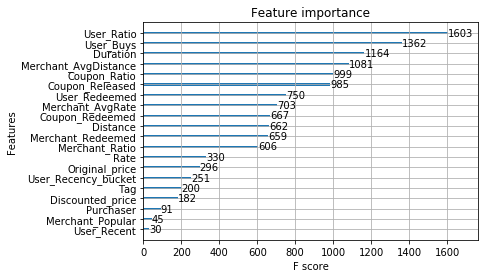

In [126]:
predictions, output, y_test, predicted_values= train_model(train_dataset)

In [118]:
output.head()

,User_id,Merchant_id,Date_received,Probabilities
881955,6396845,1945,2016-05-19,0.000026
430973,3132033,3381,2016-02-05,0.000026
493855,3591950,6454,2016-02-07,0.000025
55884,407088,8386,2016-01-24,0.000024
710594,5159867,3381,2016-01-27,0.000028


In [128]:
def evaluate_model(predictions, predicted_values, y_test):
    roc_score = round(roc_auc_score(y_test, predictions), 3)

    print('ROC AUC Score of Probailities:  '+ str(roc_score))
    print('ROC AUC Curve')
    fpr, tpr, _ = metrics.roc_curve(y_test, predictions)
    auc = metrics.roc_auc_score(y_test, predictions)
    plt.plot(fpr,tpr,label="auc="+str(auc))
    plt.legend(loc=4)
    plt.show()
    
    predicted_values = [1 if x>=0.40 else 0 for x in predictions]

    print('\n The classification report for the model:')
    print(classification_report(y_test, predicted_values) )
    results = confusion_matrix(y_test, predicted_values) 
    print('\n The confusion matrix for the model:')
    print(results)

ROC AUC Score of Probailities:  0.981
ROC AUC Curve


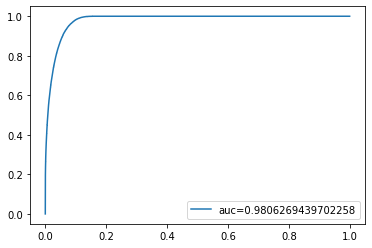


 The classification report for the model:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98    285907
           1       0.70      0.66      0.68     18710

    accuracy                           0.96    304617
   macro avg       0.84      0.82      0.83    304617
weighted avg       0.96      0.96      0.96    304617


 The confusion matrix for the model:
[[280562   5345]
 [  6358  12352]]


In [120]:
evaluate_model(predictions, predicted_values, y_test)

ROC AUC Score of Probailities:  0.981
ROC AUC Curve


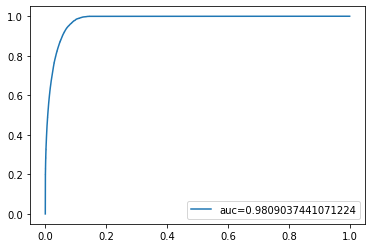


 The classification report for the model:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98    285907
           1       0.69      0.68      0.69     18710

    accuracy                           0.96    304617
   macro avg       0.83      0.83      0.83    304617
weighted avg       0.96      0.96      0.96    304617


 The confusion matrix for the model:
[[280122   5785]
 [  5934  12776]]


In [129]:
evaluate_model(predictions, predicted_values, y_test)